C:\Users\luisf\AppData\Local\Temp\ipykernel_11880\1375693951.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\luisf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\_lib\_util.py:714: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for el in a.ravel():
C:\Users\luisf\AppData\Local\Temp\ipykernel_11880\1375693951.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R²: 0.9140352164004398
MSE: 5993500.319898479
MAE: 1453.8350851196626
Durchschnittspreis: 13760.999147000284
       Actual  Predicted
61506   14980   15688.05
1631     3900    3210.03
10247    4600    5016.53
9183     4150    3551.83
53760   13490   13216.58
...       ...        ...
44184   11990    8972.14
37994   11900   13020.47
41106   13900   14388.27
6032     3750    3007.35
16451   22500   23209.55

[704 rows x 2 columns]
                       Feature  Importance
2                        Alter    0.770561
1                     power_ps    0.120872
3                mileage_in_km    0.065609
0                    Verbrauch    0.023163
4     transmission_type_Manual    0.010017
5  transmission_type_Automatic    0.009778


C:\Users\luisf\AppData\Local\Temp\ipykernel_11880\1375693951.py:79: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Diagonale Linie


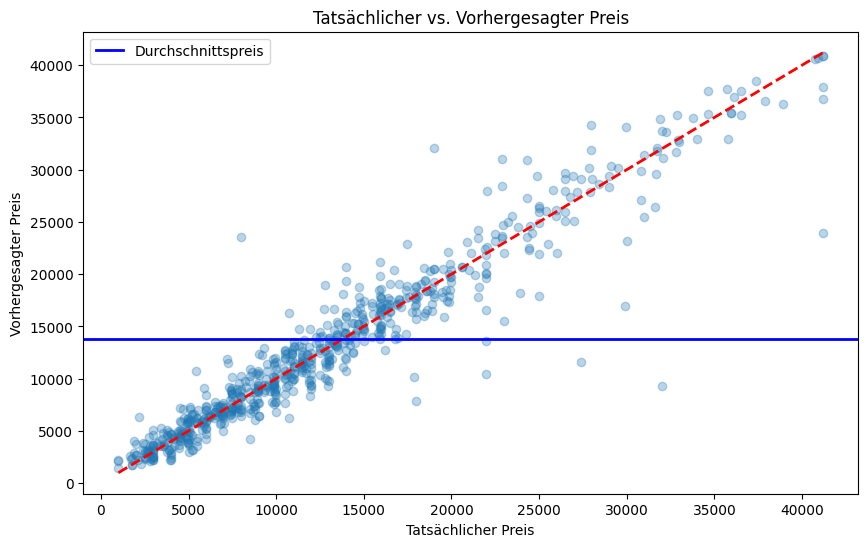

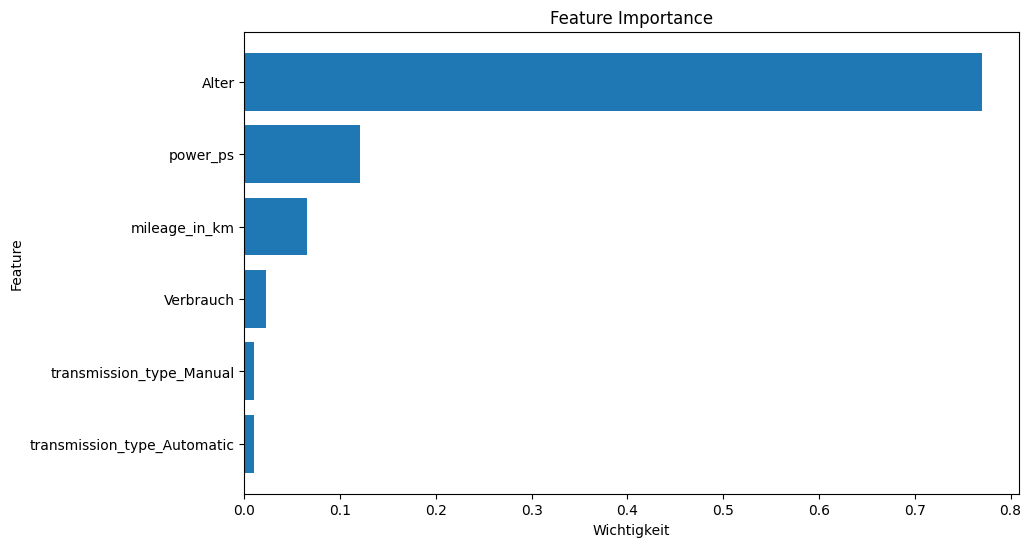

In [1]:
##nur VWGOLF
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

file_path = 'C:\\Desktop\\Datensätze Reg\\DatensatzReg1602gek.csv'

df = pd.read_csv(file_path, delimiter=";")

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['brand', 'model', 'color', 'transmission_type', 'fuel_type'])

# Filtern des DataFrames
df_filtered = df[(df['model_Volkswagen Golf'] == 1)]
                 
# Winsorizing der Spalten 'Verbrauch', 'power_ps', 'Alter', 'mileage_in_km', und 'price_in_euro' 
df_filtered['Verbrauch'] = winsorize(df_filtered['Verbrauch'], limits=[0.01, 0.01])
df_filtered['power_ps'] = winsorize(df_filtered['power_ps'], limits=[0.01, 0.01])
df_filtered['Alter'] = winsorize(df_filtered['Alter'], limits=[0.01, 0.01])
df_filtered['mileage_in_km'] = winsorize(df_filtered['mileage_in_km'], limits=[0.01, 0.01])
df_filtered['price_in_euro'] = winsorize(df_filtered['price_in_euro'], limits=[0.01, 0.01])

# Konvertierung der Spalten, die Kommas als Dezimaltrennzeichen verwenden könnten
columns_to_convert = ['Verbrauch', 'Alter']

for column in columns_to_convert:
    if column in df_filtered.columns:
        df_filtered[column] = df_filtered[column].astype(str).str.replace(',', '.').astype(float)

# Begrenzen des Kilometerstandes, Alters und der Preisrange auf vernünftige Bereiche
df_filtered = df_filtered[(df_filtered['mileage_in_km'] >= 0) & (df_filtered['mileage_in_km'] <= 200000)]
df_filtered = df_filtered[(df_filtered['price_in_euro'] >= 500) & (df_filtered['price_in_euro'] <= 70000)]
#df_filtered = df_filtered[(df_filtered['power_ps']>=60) & (df_filtered['power_ps'] <= 160)]

df_filtered = df_filtered.dropna()

# Wähle die relevanten Features und die Zielvariable aus
X = df_filtered[['Verbrauch', 'power_ps', 'Alter', 'mileage_in_km', 'transmission_type_Manual', 'transmission_type_Automatic']]
y = df_filtered['price_in_euro']

# Teile die Daten in Trainings- und Testsets auf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisiere und trainiere den Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Mache Vorhersagen und bewerte das Modell
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
average_price = df_filtered['price_in_euro'].mean()

print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"Durchschnittspreis: {average_price}")


# DF mit den tatsächlichen und den vorhergesagten Werten erstellen
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Feature Importance anzeigen
importance = model.feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame(list(zip(feature_names, importance)), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

# Prediction df + Feature importance ausgeben
print(predictions_df)
print(feature_importance)

# Visualisierung der tatsächlichen gegen die vorhergesagten Werte + Durschhnitswert als Gerade
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Diagonale Linie
plt.axhline(y=average_price, color='blue', linestyle='-', lw=2, label='Durchschnittspreis')
plt.xlabel('Tatsächlicher Preis')
plt.ylabel('Vorhergesagter Preis')
plt.title('Tatsächlicher vs. Vorhergesagter Preis')
plt.legend()
plt.show()

# Visualisierung der Feature Importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importance}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Wichtigkeit')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Um die wichtigsten Features oben zu haben
plt.show()

#predictions_df.to_excel('C:\\Desktop\\Datensätze Reg\\preddf\\predictionsdf.xlsx')
